## **Accessing the Dataset**

Authenticating kaggle account to access resources programatically

In [ ]:
# Setting Up Kaggle API Authentication
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Downloading dataset from kaggle

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [01:21<00:00, 23.6MB/s]
100% 1.76G/1.76G [01:21<00:00, 23.3MB/s]


In [ ]:
# importing libraries
import os
import matplotlib.pyplot  as plt
import numpy as np
import cv2
import zipfile
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image
from ipywidgets import widgets, VBox, Output
from IPython.display import display
from io import BytesIO

Extracting the dataset zip file

In [ ]:
# Extracting Dataset from ZIP File
zip_ref = zipfile.ZipFile("/content/lung-and-colon-cancer-histopathological-images.zip")
zip_ref.extractall('/content')
zip_ref.close()

## **Exploratory Data Analysis**

In [ ]:
DATADIR = '/content/lung_colon_image_set/lung_image_sets'
CATEGORIES = ['lung_n','lung_aca', 'lung_scc']

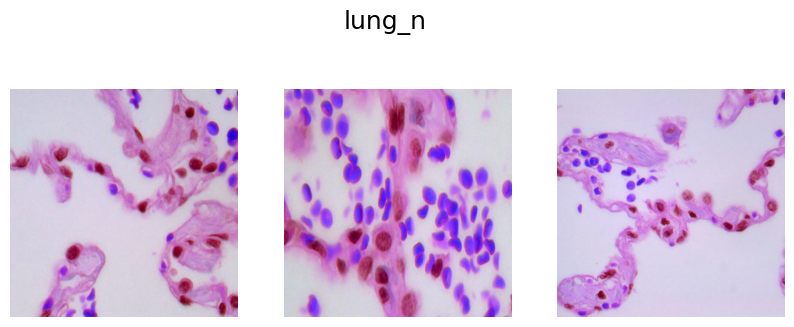

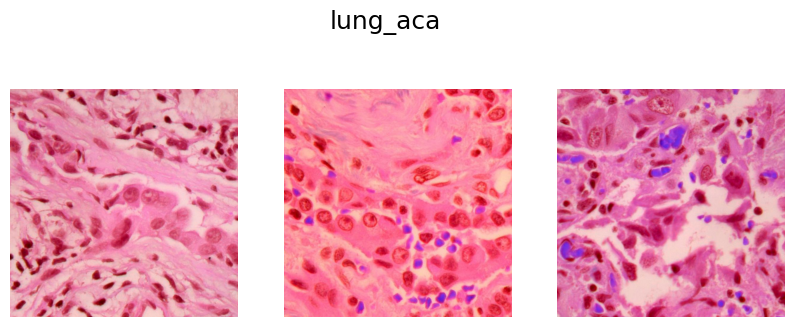

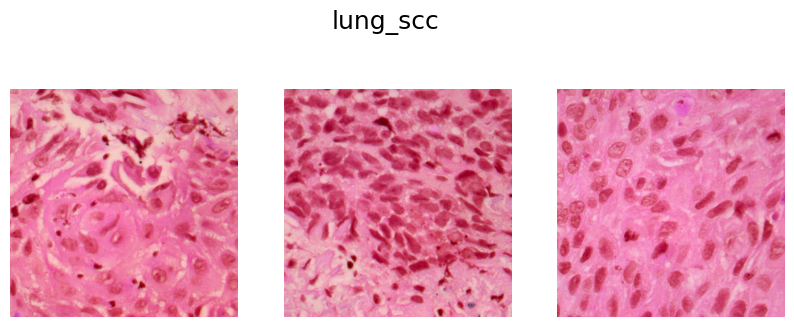

In [ ]:
# Visualizing Sample Images from Each Category
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  images = os.listdir(path)

  fig, ax = plt.subplots(1,3, figsize =(10,4))
  fig.suptitle(f'{category}',fontsize = 18)
  for i in range (3):
    img_name = images[np.random.randint(0,len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')


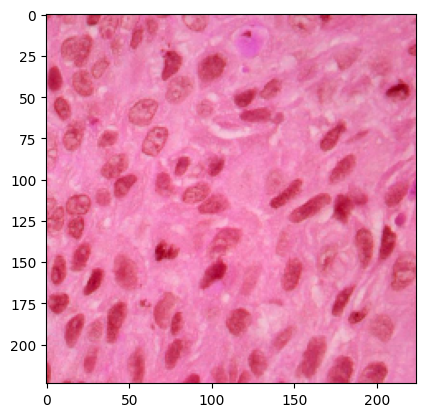

In [ ]:
# Resizing and Displaying an Image
IMG_SIZE = 224
new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)

In [ ]:
new_array.shape

(224, 224, 3)

## **Preparing the training data**

In [ ]:
training_data =[]
#create trtaining data
def create_train_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,labels])
      except Exception as e:
        pass
create_train_data()


In [ ]:
len(training_data)

15000

In [ ]:
X=[]
y=[]

for features,labels in training_data:
  X.append(features)
  y.append(labels)

In [ ]:
type(X), type(y)

(list, list)

In [ ]:
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array(y)

In [ ]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## **Train-test split**

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print(f'X_train Length: {X_train.shape[0]}, X_train Image_size : {X_train.shape[1:3]}, X_train Channel dimesnion : {X_train.shape[3]}')
print(f'X_test Length: {X_test.shape[0]}, X_test Image_size : {X_test.shape[1:3]}, X_test Channel dimesnion : {X_test.shape[3]}')
print(f'X_val Length: {X_val.shape[0]}, X_val Image_size : {X_val.shape[1:3]}, X_val Channel dimesnion : {X_val.shape[3]}')

X_train Length: 10500, X_train Image_size : (224, 224), X_train Channel dimesnion : 3
X_test Length: 2250, X_test Image_size : (224, 224), X_test Channel dimesnion : 3
X_val Length: 2250, X_val Image_size : (224, 224), X_val Channel dimesnion : 3


## **Importing important libraries**

In [ ]:
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#freezing convolution layers
for layer in vgg.layers:
  layer.trainable = False

## **Training the model**

In [ ]:
# adding top layers
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation ='relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # Save best model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=5,  # Patience of 3 epochs without improvement
    restore_best_weights=True,  # Restore the best weights when stopping
    mode='max',  # Minimize validation loss
    verbose=1
)

In [ ]:
model.compile(optimizer ='adam',
loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 40, validation_data=(X_val, y_val),callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8847 - loss: 0.7316
Epoch 1: val_accuracy improved from -inf to 0.97067, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 204ms/step - accuracy: 0.8849 - loss: 0.7301 - val_accuracy: 0.9707 - val_loss: 0.0872
Epoch 2/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9712 - loss: 0.0730
Epoch 2: val_accuracy did not improve from 0.97067
329/329 ━━━━━━━━━━━━━━━━━━━━ 115s 170ms/step - accuracy: 0.9712 - loss: 0.0730 - val_accuracy: 0.9698 - val_loss: 0.0754
Epoch 3/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9772 - loss: 0.0661
Epoch 3: val_accuracy improved from 0.97067 to 0.98356, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9772 - loss: 0.0661 - val_accuracy: 0.9836 - val_loss: 0.0405
Epoch 4/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9856 - loss: 0.0358
Epoch 4: val_accuracy did not improve from 0.98356
329/329 ━━

## **Evaluating the model performance**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model accuracy; {accuracy*100}')

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9903 - loss: 0.0274
Model accuracy; 99.02222156524658


In [ ]:
pred = np.argmax(model.predict(X_test),axis= -1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step


In [ ]:
y_test[:5]

array([1, 0, 1, 2, 1])

In [ ]:
pred[:5]

array([1, 0, 1, 2, 1])

In [ ]:
# Generating classification report and confusion matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       773
           1       0.99      0.98      0.99       741
           2       0.98      1.00      0.99       736

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



Text(50.722222222222214, 0.5, 'actual')

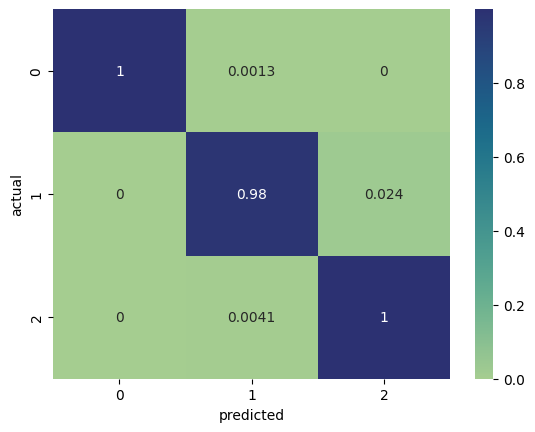

In [ ]:
cf = confusion_matrix(y_test,pred,normalize='true')
sns.heatmap(cf, annot =True,cmap ='crest')
plt.xlabel('predicted')
plt.ylabel('actual')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,869,643 (68.17 MB)

 Trainable params: 1,051,651 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,103,304 (8.02 MB)

In [ ]:
labels = ["Benign ", "aca", "scc"]
# Upload widget
uploader = widgets.FileUpload(accept="image/*", multiple=False)
output = Output()

def classify(change):
    with output:
        output.clear_output()
        # Access uploaded file content
        uploaded_file = next(iter(uploader.value.values()))
        content = uploaded_file['content']  # Get bytes content
        image = Image.open(BytesIO(content))  # Wrap bytes in BytesIO for PIL

        # Display uploaded image
        display(image)

        # Preprocess image
        image_array = np.array(image.resize((224, 224)))
        if len(image_array.shape) == 2:  # If grayscale, convert to RGB
            image_array = np.stack([image_array] * 3, axis=-1)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(image_array)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]

        # Display prediction
        print(f"Predicted Label: {labels[predicted_class_idx]}")
        print(f"Confidence: {confidence:.2f}")

uploader.observe(classify, names="value")
display(VBox([uploader, output]))